# 설치

In [1]:
pip install geopandas

In [2]:
pip install pulp

In [3]:
pip install pydeck==0.5.0

In [4]:
# matplotlib 한글 글꼴
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

# setting

In [5]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import json
import random
import matplotlib.pylab as plt
import os
%matplotlib inline

# MCLP를 위한 선형계획법 툴
from pulp import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

# 데이터 불러오기, geometry column 추가

In [8]:
# 수요지 데이터
# 담배무단투기데이터
smoke = pd.read_csv('/content/drive/MyDrive/2024-1 KUBIG 분류예측/Data/강남구_담배꽁초무단투기적발내역_적발횟수_상위10프로_좌표계_교정_업데이트.csv', encoding = 'cp949')
smoke["geometry"] = "0"
smoke = gpd.GeoDataFrame(smoke, geometry=gpd.points_from_xy(smoke.x, smoke.y))

smoke.head()

,위반장소,도로명주소,적발횟수,x,y,geometry
0,강남역 11번출구,서울특별시 강남구 강남대로 406,2346,202372.8665,444081.4915,POINT (202372.867 444081.492)
1,역삼동 강남대로406,서울특별시 강남구 강남대로406,1646,202372.8665,444081.4915,POINT (202372.867 444081.492)
2,강남역 1번출구,서울특별시 강남구 강남대로 390,1019,202459.3073,443962.5665,POINT (202459.307 443962.567)
3,역삼동 강남대로408,서울특별시 강남구 강남대로408,585,202365.2724,444112.3110,POINT (202365.272 444112.311)
4,강남역 메리츠빌딩,서울특별시 강남구 강남대로 382,339,202461.7287,443871.6837,POINT (202461.729 443871.684)


In [9]:
# 적발횟수 10회 이상인 경우만 남긴다. (연간 5회 이상 적발 구역)
smoke = smoke[smoke['적발횟수']>=10]

In [10]:
smoke

,위반장소,도로명주소,적발횟수,x,y,geometry
0,강남역 11번출구,서울특별시 강남구 강남대로 406,2346,202372.8665,444081.4915,POINT (202372.867 444081.492)
1,역삼동 강남대로406,서울특별시 강남구 강남대로406,1646,202372.8665,444081.4915,POINT (202372.867 444081.492)
2,강남역 1번출구,서울특별시 강남구 강남대로 390,1019,202459.3073,443962.5665,POINT (202459.307 443962.567)
3,역삼동 강남대로408,서울특별시 강남구 강남대로408,585,202365.2724,444112.3110,POINT (202365.272 444112.311)
4,강남역 메리츠빌딩,서울특별시 강남구 강남대로 382,339,202461.7287,443871.6837,POINT (202461.729 443871.684)
...,...,...,...,...,...,...
266,역삼동 테헤란로327,역삼동 테헤란로327,10,204107.6890,444690.3809,POINT (204107.689 444690.381)
267,역삼동 테헤란로4길25,역삼동 테헤란로4길25,10,203025.3762,444411.3205,POINT (203025.376 444411.320)
268,역삼동 테헤란로4길32,역삼동 테헤란로4길32,10,202598.4948,443785.8347,POINT (202598.495 443785.835)
269,역삼동 테헤란로4길46,역삼동 테헤란로4길46,10,202599.6336,443667.5212,POINT (202599.634 443667.521)


In [11]:
# 후보지, 가중치 데이터프레임
# (담배소매업체, 버퍼 내 시설 개수)
shop = pd.read_csv('/content/drive/MyDrive/2024-1 KUBIG 분류예측/Data/버퍼내근린시설개수_담배소매업기준_시설13개.csv')
shop["geometry"] = "0"
shop = shop[['번호','사업장명', '좌표정보(X)','좌표정보(Y)','인터넷시설개수', '노래방개수', '휴게음식점개수', '음식점개수', '유흥주점개수', '단란주점개수', '목욕장개수',
       '체력단련장개수', '골프장개수', '관광식당개수', '숙박업개수', '관광숙박업개수', '대규모점포개수', 'geometry']]
shop = gpd.GeoDataFrame(shop, geometry=gpd.points_from_xy(shop['좌표정보(X)'], shop['좌표정보(Y)']))
shop = shop.rename(columns={'좌표정보(X)': 'x', '좌표정보(Y)': 'y'})

shop.head()

,번호,사업장명,x,y,인터넷시설개수,노래방개수,휴게음식점개수,음식점개수,유흥주점개수,단란주점개수,목욕장개수,체력단련장개수,골프장개수,관광식당개수,숙박업개수,관광숙박업개수,대규모점포개수,geometry
0,1,지에스25청담영동점,203553.889959,446266.149102,0,0,20,34,0,1,1,6,0,0,0,0,0,POINT (203553.890 446266.149)
1,2,세븐일레븐 선정릉점(셀프빨래방),203737.434406,445369.080148,0,0,10,28,0,2,0,1,0,0,0,0,0,POINT (203737.434 445369.080)
2,3,움편주식회사,203422.080760,444874.498704,0,0,10,27,0,1,1,0,0,0,0,0,0,POINT (203422.081 444874.499)
3,4,(주)에스피씨삼립시티델리 도곡사옥점,203551.136336,442643.023090,0,0,0,1,0,0,0,0,0,0,0,0,0,POINT (203551.136 442643.023)
4,5,지에스 25 대치오토웨이점,205564.090602,444887.741603,0,0,6,10,0,0,0,0,0,0,0,0,0,POINT (205564.091 444887.742)


## 전처리 (중복제거) - shop

### 중복 확인

In [12]:
len(shop)

1051

In [13]:
shop.geometry.nunique()

979

In [14]:
duplicates = shop[shop.duplicated(subset=['geometry'], keep=False)]['geometry'].unique()
print(duplicates)

<GeometryArray>
[<POINT (202462.605 443960.186)>,  <POINT (205314.16 445204.709)>,
  <POINT (205185.57 444964.439)>,  <POINT (203518.763 446051.58)>,
 <POINT (204062.156 444460.973)>,  <POINT (204409.706 443065.55)>,
 <POINT (206618.425 443390.561)>, <POINT (206239.624 442598.513)>,
  <POINT (204128.39 446149.795)>, <POINT (205130.592 445590.097)>,
 <POINT (202655.386 447491.029)>,   <POINT (202425.73 444852.88)>,
 <POINT (204538.145 442942.854)>,  <POINT (207194.617 442206.84)>,
 <POINT (201509.713 447234.044)>,  <POINT (204104.698 446220.28)>,
 <POINT (205707.089 443914.194)>, <POINT (206573.648 443195.189)>,
   <POINT (205255.088 443524.6)>, <POINT (202616.482 443881.282)>,
  <POINT (205496.33 443515.702)>,  <POINT (204828.18 445089.673)>,
 <POINT (204268.379 444593.807)>, <POINT (204846.902 441821.433)>,
 <POINT (205625.546 442117.096)>, <POINT (202520.972 443946.833)>,
 <POINT (202619.098 443688.692)>, <POINT (204536.822 444660.784)>,
 <POINT (202422.252 443872.484)>,  <POINT (204

In [15]:
shop[shop['geometry']==duplicates[1]]

,번호,사업장명,x,y,인터넷시설개수,노래방개수,휴게음식점개수,음식점개수,유흥주점개수,단란주점개수,목욕장개수,체력단련장개수,골프장개수,관광식당개수,숙박업개수,관광숙박업개수,대규모점포개수,geometry
8,9,지에스25 파르나스몰점,205314.159889,445204.70931,0,0,12,26,0,0,0,0,0,0,1,1,1,POINT (205314.160 445204.709)
616,617,지에스25파르나스타워점,205314.159889,445204.70931,0,0,12,26,0,0,0,0,0,0,1,1,1,POINT (205314.160 445204.709)
1011,1014,파르나스호텔(주),205314.159889,445204.70931,0,0,12,26,0,0,0,0,0,0,1,1,1,POINT (205314.160 445204.709)
1012,1015,파르나스호텔신용협동조합,205314.159889,445204.70931,0,0,12,26,0,0,0,0,0,0,1,1,1,POINT (205314.160 445204.709)


### 중복 처리

In [16]:
shop = shop.drop_duplicates(subset=['geometry'])

In [17]:
shop

,번호,사업장명,x,y,인터넷시설개수,노래방개수,휴게음식점개수,음식점개수,유흥주점개수,단란주점개수,목욕장개수,체력단련장개수,골프장개수,관광식당개수,숙박업개수,관광숙박업개수,대규모점포개수,geometry
0,1,지에스25청담영동점,203553.889959,446266.149102,0,0,20,34,0,1,1,6,0,0,0,0,0,POINT (203553.890 446266.149)
1,2,세븐일레븐 선정릉점(셀프빨래방),203737.434406,445369.080148,0,0,10,28,0,2,0,1,0,0,0,0,0,POINT (203737.434 445369.080)
2,3,움편주식회사,203422.080760,444874.498704,0,0,10,27,0,1,1,0,0,0,0,0,0,POINT (203422.081 444874.499)
3,4,(주)에스피씨삼립시티델리 도곡사옥점,203551.136336,442643.023090,0,0,0,1,0,0,0,0,0,0,0,0,0,POINT (203551.136 442643.023)
4,5,지에스 25 대치오토웨이점,205564.090602,444887.741603,0,0,6,10,0,0,0,0,0,0,0,0,0,POINT (205564.091 444887.742)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,1049,강남하드웨어,203260.792223,447182.513984,0,4,13,108,0,0,0,3,0,0,0,0,0,POINT (203260.792 447182.514)
1047,1050,늘봄식품,203133.275000,446564.390000,0,0,3,38,0,3,0,1,0,0,0,0,0,POINT (203133.275 446564.390)
1048,1051,삼성식품,204347.519885,445490.225761,0,0,9,23,3,0,0,1,0,0,1,0,0,POINT (204347.520 445490.226)
1049,1052,위드미 선릉청운점,203835.590533,445318.806286,0,0,3,12,0,1,0,0,0,0,0,0,0,POINT (203835.591 445318.806)


In [18]:
shop.reset_index(drop=True, inplace=True)

## 전처리 (중복제거) - smoke

In [19]:
print('unique한 row 개수:', smoke.geometry.nunique())
print('실제 row 개수:', len(smoke))

unique한 row 개수: 234
실제 row 개수: 271


In [20]:
# Geometry 값이 중복된 도로명주소 반환
duplicates = smoke[smoke.duplicated(subset=['geometry'], keep=False)]

def get_road_address(group):
    return group['도로명주소'].unique()

duplicates_grouped = duplicates.groupby('geometry').apply(get_road_address)

print(duplicates_grouped)

geometry
POINT (202531.592 443678.525)              [서울특별시 강남구 강남대로 362, 서울특별시 강남구 강남대로362]
POINT (202556.259 443809.894)                                 [서울특별시 강남구 테헤란로2길27]
POINT (202591.993 443813.696)                                 [서울특별시 강남구 테헤란로4길28]
POINT (202868.083 444125.072)              [서울특별시 강남구 테헤란로 132, 서울특별시 강남구 테헤란로132]
POINT (202583.938 443968.934)                                  [서울특별시 강남구 테헤란로4길5]
POINT (202372.867 444081.492)              [서울특별시 강남구 강남대로 406, 서울특별시 강남구 강남대로406]
POINT (202392.774 444064.577)              [서울특별시 강남구 강남대로 402, 서울특별시 강남구 강남대로402]
POINT (202414.733 444044.868)              [서울특별시 강남구 테헤란로101, 서울특별시 강남구 테헤란로 101]
POINT (202542.360 443939.600)                 [서울특별시 강남구 테헤란로4길6, 서울 강남구 테헤란로4길 6]
POINT (202468.835 443935.796)                                  [서울특별시 강남구 테헤란로2길8]
POINT (202459.307 443962.567)              [서울특별시 강남구 강남대로 390, 서울특별시 강남구 강남대로390]
POINT (202365.272 444112.311)              [서울특별시 강남구 강남대로408, 서울특별시 강남구 강남대로 

In [21]:
summed_df = smoke.groupby('geometry', as_index=False)['적발횟수'].sum()
summed_df = summed_df.rename(columns={'적발횟수':'적발횟수_합'})
summed_df

,geometry,적발횟수_합
0,POINT (202559.621 443605.400),23
1,POINT (202590.339 443610.582),272
2,POINT (202817.956 443102.498),10
3,POINT (202694.573 443235.769),11
4,POINT (203195.870 443270.629),10
...,...,...
229,POINT (205441.951 443494.969),71
230,POINT (207396.752 442435.119),47
231,POINT (208999.542 443004.306),35
232,POINT (209107.738 442769.309),76


In [22]:
smoke_unique = smoke.drop_duplicates(subset=['geometry'])
smoke_unique
smoke_unique.reset_index(drop=True)

,위반장소,도로명주소,적발횟수,x,y,geometry
0,강남역 11번출구,서울특별시 강남구 강남대로 406,2346,202372.8665,444081.4915,POINT (202372.867 444081.492)
1,강남역 1번출구,서울특별시 강남구 강남대로 390,1019,202459.3073,443962.5665,POINT (202459.307 443962.567)
2,역삼동 강남대로408,서울특별시 강남구 강남대로408,585,202365.2724,444112.3110,POINT (202365.272 444112.311)
3,강남역 메리츠빌딩,서울특별시 강남구 강남대로 382,339,202461.7287,443871.6837,POINT (202461.729 443871.684)
4,역삼동 테헤란로2길27,서울특별시 강남구 테헤란로2길27,331,202556.2588,443809.8936,POINT (202556.259 443809.894)
...,...,...,...,...,...,...
229,역삼동 비전타워,서울 강남구 테헤란로 312,10,203912.2786,444528.7696,POINT (203912.279 444528.770)
230,역삼동 테헤란로4길25,역삼동 테헤란로4길25,10,203025.3762,444411.3205,POINT (203025.376 444411.320)
231,역삼동 테헤란로4길32,역삼동 테헤란로4길32,10,202598.4948,443785.8347,POINT (202598.495 443785.835)
232,역삼동 테헤란로4길46,역삼동 테헤란로4길46,10,202599.6336,443667.5212,POINT (202599.634 443667.521)


In [23]:
smoke = pd.merge(smoke_unique, summed_df, on='geometry', how='left')
smoke = smoke.drop(columns = ['적발횟수'])
smoke = smoke.rename(columns={'적발횟수_합': '적발횟수'})

In [24]:
smoke.head(3)

,위반장소,도로명주소,x,y,geometry,적발횟수
0,강남역 11번출구,서울특별시 강남구 강남대로 406,202372.8665,444081.4915,POINT (202372.867 444081.492),3992
1,강남역 1번출구,서울특별시 강남구 강남대로 390,202459.3073,443962.5665,POINT (202459.307 443962.567),1041
2,역삼동 강남대로408,서울특별시 강남구 강남대로408,202365.2724,444112.3110,POINT (202365.272 444112.311),758


# MCLP

In [25]:
smoke.crs = 'epsg:5174'
shop.crs = 'epsg:5174'
smoke = smoke.to_crs(epsg=5179)
shop = shop.to_crs(epsg=5179)

In [26]:
# 각 수요지과 후보지들 간의 거리 행렬 (수요지 smoke i 기준 거리 d[i])
d= np.empty((len(smoke), len(shop)))
for i in range(len(smoke)):
    point_i= smoke.geometry[i]
    d[i]= [point_i.distance(point_j)for point_j in shop.geometry]
    if i% 50== 0:
            print('loading'+ '.'*(i//50)+ '_'*(6-i//50))
d.shape

loading______
loading._____
loading..____
loading...___
loading....__


(234, 979)

In [27]:
I = smoke.index.values #담배적발 수요지
J = shop.index.values #담배소매업체 후보지
S = 200 #커버범위

# a가 수요
a = smoke["적발횟수"]
P = 30 #선정할 입지 수

# Compute the sets Ni
# NB: this will be a list in which each item is a list of nodes
# within the threshold distance of the i'th node

#수요지와 후보지 사이 거리가 S 미만 제약 조건
N = [[j for j in J if d[i][j] < S] for i in I]

# Formulate optimisation

#MCLP
prob = LpProblem("MCLP", LpMaximize)
x = LpVariable.dicts("x", J, lowBound=0, upBound=1, cat='Integer')
y = LpVariable.dicts("y", I, lowBound=0, upBound=1, cat='Integer')

# Objective (목적함수)
prob += lpSum([a[i]*y[i] for i in I])

# Constraints (제약조건)
for i in I:
    prob += lpSum([x[j] for j in N[i]]) >= y[i]

prob += lpSum([x[j] for j in J]) == P #총 선정지 수는 P이다

# Solve problem
prob.solve()

x_soln = np.array([x[j].varValue for j in J])

x_soln

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [28]:
# And print some output
print (("Status:"), LpStatus[prob.status])
print ("Weight Covered is = ", value(prob.objective))
print ("x = ", x_soln)
shop['opt'] = x_soln
shop.head()
opt_id = shop[shop['opt'] == 1]['번호'].values

Status: Optimal
Weight Covered is =  15637.0
x =  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 

In [29]:
print(smoke['적발횟수'].sum())

15830


In [30]:
condition = (shop.opt == 1.0)
df = shop[condition]
df = df[['번호','사업장명', 'x','y','geometry']]
df

,번호,사업장명,x,y,geometry
6,7,지에스25S강남역3호점,202462.604763,443960.186303,POINT (958334.873 1944391.734)
29,30,(주)코리아세븐 논현행운점,203559.445660,446001.758937,POINT (959442.084 1946426.679)
180,182,킹콩전자담배 선릉역점,204325.143969,444689.095230,POINT (960200.523 1945110.489)
217,220,쿠커피(Coup Coffee 강남점),204669.543367,443873.621189,POINT (960540.466 1944293.520)
243,248,지에스25(GS25)역삼아르누보점,203716.938086,444579.034009,POINT (959591.979 1945003.693)
346,355,지에스(GS)25 역삼태극점,202619.098126,443688.691713,POINT (958489.867 1944119.520)
363,373,이마트24 R강남대로점,201930.835054,445229.332205,POINT (957810.036 1945663.187)
376,388,행복스토아,204103.041930,444558.775468,POINT (959977.821 1944981.398)
379,391,구름쥬스전자담배,205002.209843,445417.418890,POINT (960881.173 1945834.934)
397,411,지에스(GS25) 압구정유림점,202378.328280,446784.387935,POINT (958265.586 1947215.250)


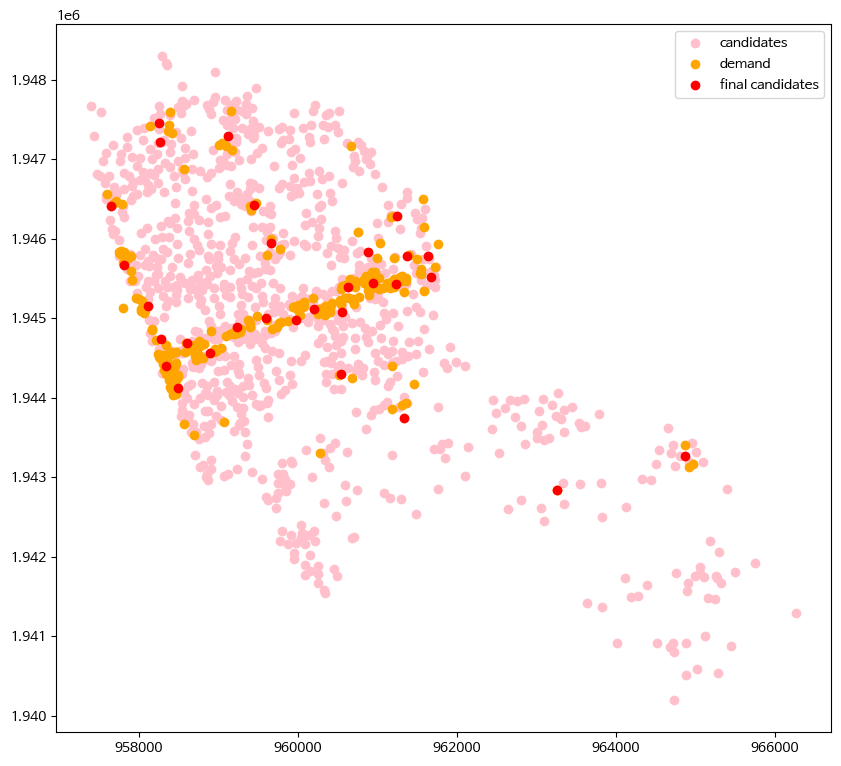

In [31]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot both GeoDataFrames on the same axis
shop.geometry.plot(ax=ax, color='pink', label='candidates')
smoke.geometry.plot(ax=ax, color='orange', label='demand')
df.geometry.plot(ax=ax, color='red', label='final candidates')

# Add legend
ax.legend()

# Show the plot
plt.show()

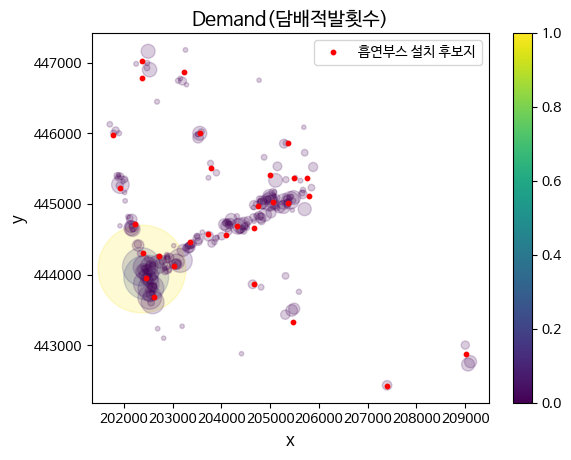

In [32]:
plt.scatter(smoke.x, # x
            smoke.y, # y
            alpha=0.2,
            s=smoke['적발횟수'], # marker size
            c=smoke['적발횟수'], # marker color
            cmap='viridis')
plt.title('Demand(담배적발횟수)', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)

plt.scatter(df.x, df.y, color='red', s=10, label='흡연부스 설치 후보지')
plt.legend()

plt.colorbar()
plt.show()

# etc

Text(0.5, 1.0, '담배꽁초 무단투기 횟수')

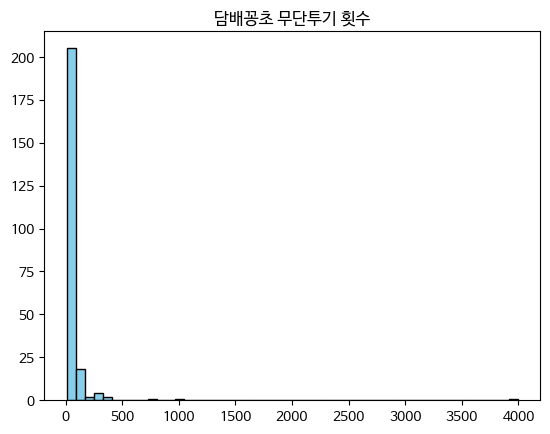

In [33]:
plt.hist(smoke['적발횟수'], bins=50, color='skyblue', edgecolor='black')
plt.title('담배꽁초 무단투기 횟수')

In [34]:
smoke_count = smoke[(smoke['적발횟수'] <= 100)]

In [35]:
smoke_count

,위반장소,도로명주소,x,y,geometry,적발횟수
22,삼성동 국민은행,서울특별시 강남구 테헤란로87길36,205111.0698,445336.1794,POINT (960989.559 1945753.151),98
23,삼성동 테헤란로81길10,서울특별시 강남구 테헤란로81길10,204995.2822,445082.1434,POINT (960872.472 1945499.830),92
24,삼성동 고반식당,서울특별시 강남구 테헤란로81길16,204983.5986,445110.3763,POINT (960860.943 1945528.114),92
25,대치동 KT&G,서울특별시 강남구 영동대로 416,205707.8557,444928.8857,POINT (961583.947 1945342.861),89
26,수서동 725,서울특별시 강남구 광평로56길 8-13,209056.3764,442729.1231,POINT (964919.462 1943126.266),88
...,...,...,...,...,...,...
229,역삼동 비전타워,서울 강남구 테헤란로 312,203912.2786,444528.7696,POINT (959786.975 1944952.414),10
230,역삼동 테헤란로4길25,역삼동 테헤란로4길25,203025.3762,444411.3205,POINT (958899.807 1944839.708),10
231,역삼동 테헤란로4길32,역삼동 테헤란로4길32,202598.4948,443785.8347,POINT (958469.786 1944216.733),10
232,역삼동 테헤란로4길46,역삼동 테헤란로4길46,202599.6336,443667.5212,POINT (958470.298 1944098.461),10


Text(0.5, 1.0, '담배꽁초 무단투기 횟수')

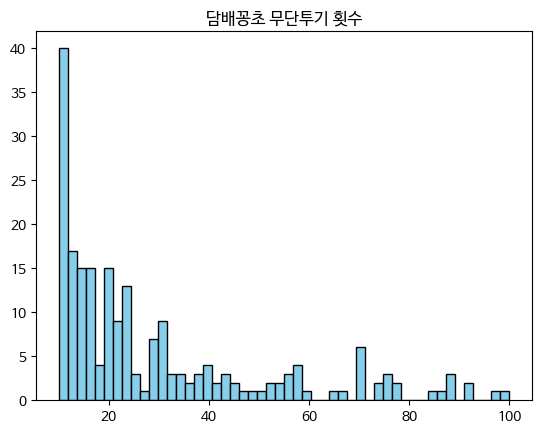

In [36]:
plt.hist(smoke_count['적발횟수'], bins=50, color='skyblue', edgecolor='black')
plt.title('담배꽁초 무단투기 횟수')

In [37]:
smoke_outlier = smoke[smoke['적발횟수']>500]

In [38]:
smoke_outlier

,위반장소,도로명주소,x,y,geometry,적발횟수
0,강남역 11번출구,서울특별시 강남구 강남대로 406,202372.8665,444081.4915,POINT (958245.813 1944513.466),3992
1,강남역 1번출구,서울특별시 강남구 강남대로 390,202459.3073,443962.5665,POINT (958331.590 1944394.131),1041
2,역삼동 강남대로408,서울특별시 강남구 강남대로408,202365.2724,444112.3110,POINT (958238.385 1944544.313),758


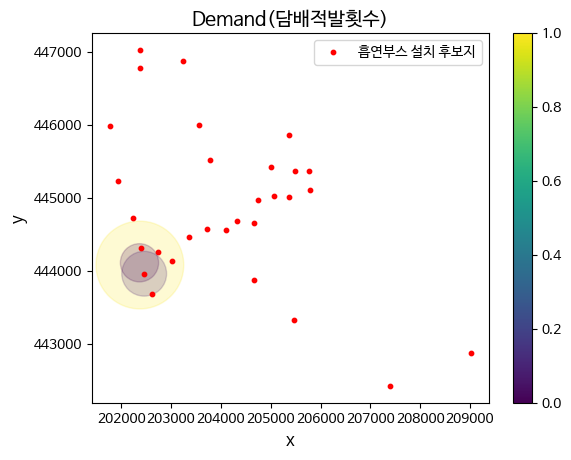

In [39]:
plt.scatter(smoke_outlier.x, # x
            smoke_outlier.y, # y
            alpha=0.2,
            s=smoke_outlier['적발횟수'], # marker size
            c=smoke_outlier['적발횟수'], # marker color
            cmap='viridis')
plt.title('Demand(담배적발횟수)', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)


plt.scatter(df.x, df.y, color='red', s=10, label='흡연부스 설치 후보지')
plt.legend()

plt.colorbar()
plt.show()

In [40]:
df.to_csv('/content/drive/MyDrive/2024-1 KUBIG 분류예측/Results/최종_MCLP_후보지선정_30개_buffer200m.csv', index=False, encoding="utf-8-sig")

# mapbox